# Aim:  
Using Milk Production Data Predict or Forecast  the Production of Milk For Next 5 Years.

In [1]:
# Lets import the library and data set

import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings("ignore")


In [2]:
# Importing the data set

df = pd.read_csv(r'C:\Users\Pratik\Downloads\monthly_milk_production.csv', parse_dates = ['Date'])


df.head()

,Date,Production
0,1962-01-01,589
1,1962-02-01,561
2,1962-03-01,640
3,1962-04-01,656
4,1962-05-01,727


In [3]:
df.isnull().sum()

Date          0
Production    0
dtype: int64

In [4]:
# As my data is inform a data frame (rows and columns), i must convert this into a pandas series by: 
# STEP A: Set the interval column as index values

ts = df.set_index("Date")

ts.head()

# STEP B: To convert the data frame into series

final_ts = ts['Production']

type(final_ts)

pandas.core.series.Series

In [5]:
ts.head()

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


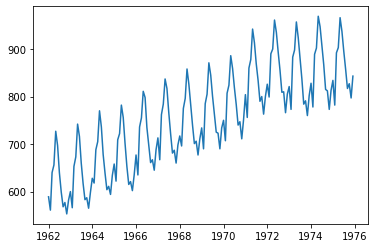

In [6]:
# Method a - By simply plotting

from matplotlib import pyplot as plt

plt.plot(final_ts)

Here we can see that the data does not have a constant average and the average value increase very year which also indicate that the data have upward trend in it.

In [7]:
# METHOD b: By ploting the rolling average (Moving Average) - As the data on x-axis is a yearly representation, and each year
# have 4 data points (as the data is a Monthly data) we will take the rolling average window of 12 data points. 
rollmean=final_ts.rolling(window=12).mean()

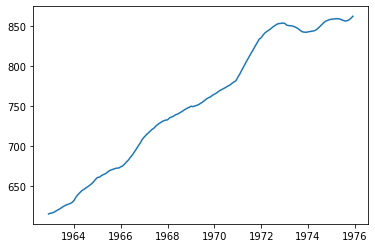

In [8]:
# Lets plot the rolling average 

plt.plot(rollmean, label = "Moving Average")
plt.show()

As the rolling average is a upward trend and is not contanst, the data is not stationary in nature

## KPSS TEST:

In [9]:
from statsmodels.tsa.stattools import kpss
stats, p, lags, critical_values = kpss(ts['Production'], 'ct')

C:\Users\Pratik\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [10]:
print(f'Test Statistics: {stats}')
print(f'p-value: {p}')
print(f'Critial Values: {critical_values}')

if p < 0.05 :
  print('Series is not Stationary')
else:
  print('Series is Stationary')

Test Statistics: 0.11850817968236364
p-value: 0.1
Critial Values: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
Series is Stationary


## Using ADF Test:

In [11]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(ts['Production'])
print(f'Test Statistics: {result[0]}')
print(f'p-value: {result[1]}')
print(f'Critial Values: {result[4]}') ## {} to get list of the critical values

if result[1] > 0.05 :
  print('Series is not Stationary')
else:
  print('Series is Stationary')

Test Statistics: -1.3038115874221246
p-value: 0.627426708603034
Critial Values: {'1%': -3.473542528196209, '5%': -2.880497674144038, '10%': -2.576878053634677}
Series is not Stationary


#### Convert the non-stationary data to stationary by the method of differencing:

Method . Differencing 
y(t) = y(t)-y(t-1)

In [12]:
# Lets peform the log tranformation

log_ts = np.log(final_ts)

log_ts

Date
1962-01-01    6.378426
1962-02-01    6.329721
1962-03-01    6.461468
1962-04-01    6.486161
1962-05-01    6.588926
                ...   
1975-08-01    6.754604
1975-09-01    6.705639
1975-10-01    6.717805
1975-11-01    6.680855
1975-12-01    6.736967
Name: Production, Length: 168, dtype: float64

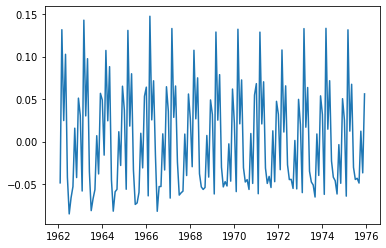

In [13]:
# Method a) differencing the time series - This can be done using shift()

diff1_ts = log_ts - log_ts.shift()

# Lets plot the diff1_ts

plt.plot(diff1_ts)

As from the above plot it look like that its a stationary time series but we can not be 100% sure thus we use dikey-fuller test

In [14]:
# Lets apply this test on diff1_ts

# as differencing the time series would have brought null value, lets drop them from the series

diff1_ts.dropna(inplace = True)

result = adfuller(diff1_ts)

result

(-2.9066334238689886,
 0.04458204040721444,
 12,
 154,
 {'1%': -3.473542528196209,
  '5%': -2.880497674144038,
  '10%': -2.576878053634677},
 -891.3948747677152)

In [15]:
## as we can see that p value is less than 0.05 so series is stationary.

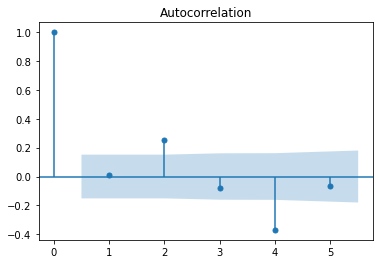

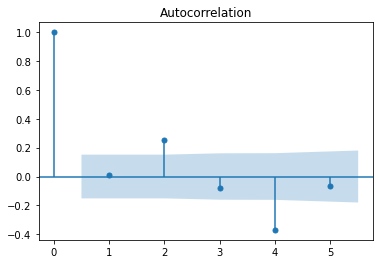

In [16]:
# Lets plot the ACF chart

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

plot_acf(diff1_ts, lags = 5)

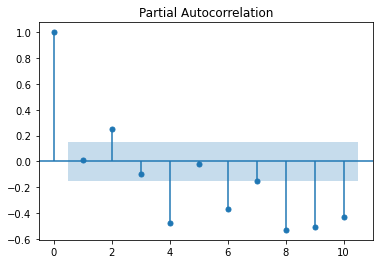

In [17]:
## PACF Plot 
pacf_plot = plot_pacf(diff1_ts,lags=10)

As at lag 1 the correlation coefficient value is Positive and signifinate we will use Auto Regression  model and thus:

p = 1 d = 1 q = 0

Lets use these value of p,d,q to build a model using a command ARIMA as below

Synatx - ARIMA(log_transformed_ts, order = (p,d,q))

In [18]:
# Lets build the ARIMA model

from statsmodels.tsa.arima_model import ARIMA

# Model

model_ar = ARIMA(log_ts, order = (1,1,0))

# Lets fit this model to get the summary of the model

summary_model = model_ar.fit(disp = False)

summary_model.summary()

C:\Users\Pratik\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Pratik\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:           D.Production   No. Observations:                  167
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 231.615
Method:                       css-mle   S.D. of innovations              0.060
Date:                Mon, 28 Feb 2022   AIC                           -457.229
Time:                        01:31:31   BIC                           -447.875
Sample:                    02-01-1962   HQIC                          -453.433
                         - 12-01-1975                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0021      0.005      0.455      0.649      -0.007       0.011
ar.L1.D.Production     0.0097      0.077      0.125      0.901      -0.142       0.162
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          103.3281           +0.0000j          103.3281            0.0000
-----------------------------------------------------------------------------
"""

I want to forecast the value for next 5 years, with a moving average window of 2 Monthly and thus I will be forecasting over all 168 + 60 data points (228) as each year contain 12 datapoints.

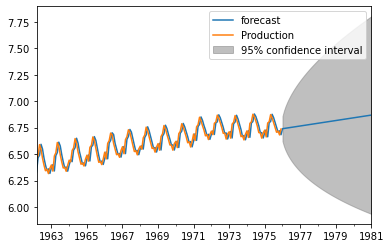

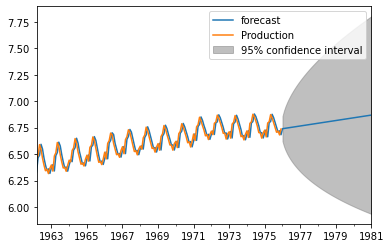

In [19]:
# Predict the values

summary_model.plot_predict(2,228)


Output:

On average np.exp(6.75) ~854 liter milk will be Produced every month from 1976 to 1981. With 95% confidence, I can say that Amount of Milk Produced per month will be between np.exp(6) ~ 403 to np.exp(7.75) ~ 2321 Liter.

In [20]:
np.exp(7.75)

2321.572414611057

In [21]:
np.exp(6)

403.4287934927351